Attempt to go from a JaxPM density field to f_scalar and rho, in order to call HPM table

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax
import jax.numpy as jnp

import jax_cosmo as jc

from jax.experimental.ode import odeint
from jaxpm.painting import cic_paint, cic_paint_2d
from jaxpm.pm import linear_field, lpt, make_ode_fn
from jaxpm.lensing import density_plane, convergence_Born


In [3]:
# Below are a few parameters that generate a low resolution version of the k-TNG simulation

box_size = [200.,200.,4000.]    # Transverse comoving size of the simulation volume Mpc/h
nc = [64, 64, 1280]              # Number of transverse voxels in the simulation volume
lensplane_width = 102.5         # Width of each lensplane
field_size = 5                  # Size of the lensing field in degrees
field_npix = 128                # Number of pixels in the lensing field
z_source = jnp.linspace(0,2)    # Source planes
# print(z_source)

In [4]:
z_start = 50
a_start = 1./(1+z_start)
print(a_start)

0.0196078431372549


In [5]:
# Defining the coordinate grid for lensing map
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [6]:
Omega_c = 0.2589
sigma8 = 0.8159
    
# Instantiates a cosmology with desired parameters
cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

# Planning out the scale factor stepping to extract desired lensplanes
n_lens = int(box_size[-1] // lensplane_width)
r = jnp.linspace(0., box_size[-1], n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])

# Retrieve the scale factor corresponding to these distances
a = jc.background.a_of_chi(cosmology, r)
a_center = jc.background.a_of_chi(cosmology, r_center)

# Then one step per lens plane
stages = a_center[::-1]


/Users/chihwaychang/anaconda3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


In [7]:
# print(1/stages-1)

In [8]:
# Create a small function to generate the matter power spectrum
k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(cosmology, k)
pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

# Create initial conditions
initial_conditions = linear_field(nc, box_size, pk_fn, seed=jax.random.PRNGKey(0))

# Create particles
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in nc]),axis=-1).reshape([-1,3])

cosmo = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

# Initial displacement
dx, p, f = lpt(cosmo, initial_conditions, particles, a_start)

# Evolve the simulation forward
res = odeint(make_ode_fn(nc), [particles+dx, p],
             jnp.concatenate([jnp.atleast_1d(a_start), stages]), cosmo, rtol=1e-5, atol=1e-5)


In [9]:
XX = 10
print(res[0][XX].shape)
print(a_center[XX])
print(1./a_center[XX]-1)
# put these particles into a 3D grid

# what is 5 deg at redshift ~0.5?

(5242880, 3)
0.71580267
0.3970331


In [245]:
# scatter(res[0][10][:,0], res[0][10][:,1])
# box_particles = res[0][res[0][10][:,2]<=64]

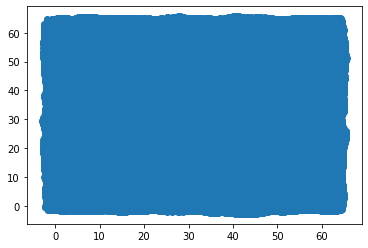

In [246]:
scatter(res[0][XX][:,0], res[0][XX][:,1])

In [247]:
H, edges = np.histogramdd(res[0][XX], range=((0,64),(0,64), (0,320)), bins = (64, 64, 1280))

In [10]:
H = cic_paint(jnp.zeros((64,64,1280)), res[0][XX])

In [335]:
# imshow(myrho[:,:,100], origin='lower', cmap='RdPu')
# colorbar()
# title('rho_m')


In [11]:
# calculate mass per particle

h = 0.7

# number of particles
print(len(res[0][XX]))

# critical density of the universe at this redshift
#rho_crit = 3*H**2 / 8 / np.pi / GG
rho_crit = 8.5 * 10**-27 #kg/m3

# Omega_m
print(jc.background.Omega_m_a(cosmo, a_center[XX]))

# rho_m_mean in kg/m^3
rho_m_mean = rho_crit*0.54765964 #jc.background.Omega_m_a(cosmo, a_center[XX])
print(rho_m_mean)

# we need this in (Msun/h)/(Mpc/h)^3
rho_m_mean = rho_m_mean *(3.086*10**22/h)**3 * (1.989*10**30/h)**(-1)  #* (3.086*10**19)**3
print(rho_m_mean)

# derive what each particle weighs
Mpart= rho_m_mean * (200*200*4000)/len(res[0][XX])
print(Mpart)

5242880
0.54765964
4.65510694e-27
140373964089.9785
4283873415831.8633


In [12]:
# rho_m = (H-np.mean(H))*1.0/np.mean(H)
rho_m = H * Mpart

In [ ]:
hist(rho_m.flatten(), bins=100)
title('rho_m at z~'+str(1./a_center[XX]-1))

In [13]:
from numpy.fft import fftn
import numpy.fft as nf

def create_kgrid(nx, ny, nz, lx, ly, lz):
    """
    Create a 3D k grid for Fourier space calculations
    """
    xres   = lx/nx #Mpc/h
    yres   = ly/ny #Mpc/h
    zres   = lz/nz #Mpc/h

    kx = nf.fftshift(np.fft.fftfreq(nx, xres))# h/Mpc
    ky = nf.fftshift(np.fft.fftfreq(ny, yres))# h/Mpc
    kz = nf.fftshift(np.fft.fftfreq(nz, zres))# h/Mpc
    
    mg = np.meshgrid(kx,ky,kz)

    #km = np.sqrt(np.sum((m**2 for m in mg)))
    km  = np.sqrt(mg[0]**2+mg[1]**2+mg[2]**2)
    #k2[nx/2,ny/2,nz/2]=1.
    print(np.min(km))
    return km

In [14]:
F_rhom = np.fft.fftshift(np.fft.fftn(rho_m))

In [15]:
kg = create_kgrid(rho_m.shape[0], rho_m.shape[1], rho_m.shape[2], lx=200, ly=200, lz=4000)
kg[np.where(kg==0)[0]]=np.inf

0.0


In [16]:
G = 6.67e-11             # m^3/kg/s^2
G = G*1.99e30            # m^3/Msun/s^2
G = G/(3.086e22)**2/1000 # (km)(Mpc^2)/Msun/s^2
G = G*3.15e16            # (km)(Mpc^2)/Msun/s/Gyr

#F_fscalar = 2*np.pi**2*G*F_rhom/kg*(1-np.exp(-kg**2*rssq))  *1.99e30/1000/(3.086e22)**2 * 3.1536e16 * 0.677 #(km/s)/Gyr
F_fscalar = 2*np.pi**2*G*F_rhom/kg # m^3/kg/s^2 (Msun/h)/(Mpc/h)^2  

R_fscalar = np.fft.ifftn(np.fft.ifftshift(F_fscalar)) 
# (m^3 Msun/h)/(kg*s^2 (Mpc/h)^2)) 
# (L^3 M)/(MT^2L^2)
# L/T^2

# 1 Gyr = 3.1536 × 10**16 s
# 1 Msun = 1.989e+30 kg
# 1 Mpc = 3.086e+19 km

# we want km/s/Gyr [L/T^2] -- in the paper

R_fscalar -= np.min(R_fscalar.real)  

# Lbox in Mpc/h

In [17]:
h = 0.7
R_fscalar_new = R_fscalar * (10**(-3))**3 * (1.989* 10**30 / h)  * 3.1536 * 10**16 / (3.086*10**19/h)**2 

/Users/chihwaychang/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/chihwaychang/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/chihwaychang/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py:1966: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


Text(0.5, 0, 'fscalar')

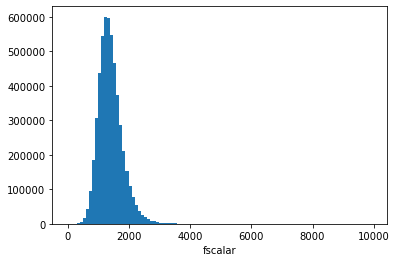

In [18]:
# hist(R_fscalar.flatten(), bins=100)
hist(R_fscalar_new.flatten(), bins=100)
xlabel('fscalar')

In [19]:
rho_m.shape

(64, 64, 1280)

Text(0.5, 1.0, 'R_fscalar')

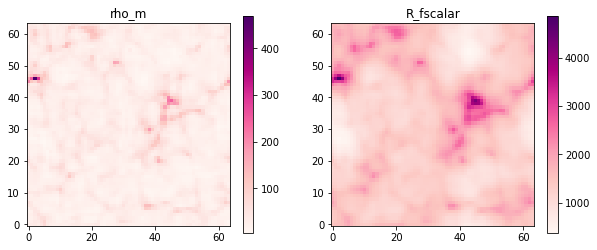

In [20]:
figure(figsize=(10,4))

subplot(121)
imshow(real(rho_m[:,:,100]/rho_m_mean), origin='lower', cmap='RdPu')
colorbar()
title('rho_m')

subplot(122)
imshow(real(R_fscalar_new[:,:,100]), origin='lower', cmap='RdPu')
colorbar()
title('R_fscalar')

Text(0.5, 1.0, 'R_fscalar')

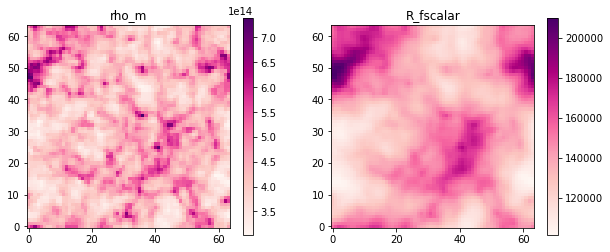

In [21]:
figure(figsize=(10,4))

subplot(121)
imshow(np.sum(real(rho_m[:,:,:100]),axis=2), origin='lower', cmap='RdPu')
colorbar()
title('rho_m')

subplot(122)
imshow(np.sum(real(R_fscalar_new[:,:,:100]),axis=2), origin='lower', cmap='RdPu')
colorbar()
title('R_fscalar')


In [22]:
# # plot res as a function of redshift
# for i in range(39)[::5]:
#     H, edges = np.histogramdd(res[0][i], range=((0,64),(0,64), (0,1280)), bins = (64, 64, 1280))
#     rho_m = (H-np.mean(H.flatten()))*1.0/np.mean(H.flatten())
#     imshow(np.sum(real(rho_m[:,:,:100]),axis=2), vmin=-1, vmax=300, origin='lower', cmap='RdPu')
#     colorbar()
#     figure()

In [23]:
# Load hpm table
f  = open('hpm_table_z00.01.dat', 'rb')
dd = np.fromfile(f, dtype=np.int32,count=2);print(dd)
X  = np.fromfile(f, dtype=np.float32) 
Y  = X.reshape((dd[1],dd[0],14))

# Set up an interpolator
drho = Y[0,:,4]
psi  = Y[:,0,5]

Tt   = Y[:,:,8].astype(np.float64)  # [K]

'''
Pt   = Y[:,:,10].astype(np.float64) # [keV/cm^3]
Pt   = Pt*1000                      # [eV/cm^3]
Pt   = Pt*(3e8)**2                  # [(eV/c^2)*(m/s)^2/cm^3]
Pt   = Pt*1.783e-36                 # [(kg)*(m/s)^2/cm^3]
Pt   = Pt/1.99e30                   # [(Msun)*(m/s)^2/cm^3]
Pt   = Pt/(1000)**2                 # [(Msun)*(km/s)^2/cm^3]
Pt   = Pt*(3.086e24)**3             # [(Msun)*(km/s)^2/Mpc^3]
Pt   = Pt/h**2                      # [h^2(Msun)*(km/s)^2/Mpc^3]
'''

Pt   = Y[:,:,10].astype(np.float64) # [keV/cm^3]
Pt   = Pt*1000                      # [eV/cm^3]
Pt   = Pt*(1.602e-19)               # [kg m^2/s^2 /cm^3]
Pt   = Pt/1.98847e30                # [Msun m^2/s^2 /cm^3]
Pt   = Pt/1000/1000                 # [Msun km^2/s^2 /cm^3]
Pt   = Pt*(3.086e24)**3             # [Msun km^2/s^2 /Mpc^3]
Pt   = Pt/h**2                      # [h^2(Msun)*(km/s)^2/Mpc^3]


#--------------> Pt is x10^10 high

from scipy.interpolate import RegularGridInterpolator
intpT = RegularGridInterpolator((psi,drho), Tt, bounds_error=False, fill_value=0)
intpP = RegularGridInterpolator((psi,drho), Pt, bounds_error=False, fill_value=0)

[145  70]


In [24]:
R_fscalar_new2 = R_fscalar_new.real
Tf = intpT( np.c_[(R_fscalar_new2.real).flatten(), (rho_m/np.mean(rho_m)).flatten() ]).reshape((64,64,1280))
Pf = intpP( np.c_[(R_fscalar_new2.real).flatten(), (rho_m/np.mean(rho_m)).flatten() ]).reshape((64,64,1280))

Text(0.5, 1.0, 'log(P)')

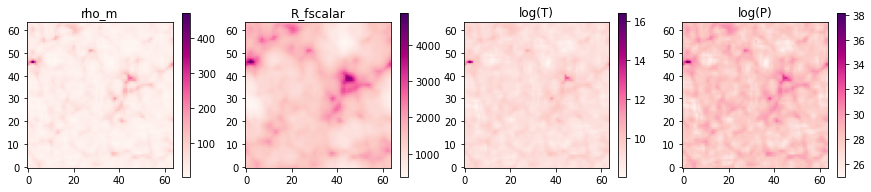

In [27]:
figure(figsize=(15,3))

subplot(141)
imshow(real(rho_m[:,:,100]/rho_m_mean), origin='lower', cmap='RdPu')
colorbar()
title('rho_m')

subplot(142)
imshow(real(R_fscalar_new[:,:,100]), origin='lower', cmap='RdPu')
colorbar()
title('R_fscalar')

subplot(143)
imshow(np.log(real(Tf[:,:,100])), origin='lower', cmap='RdPu')
colorbar()
title('log(T)')

subplot(144)
imshow(np.log(real(Pf[:,:,100])), origin='lower', cmap='RdPu')
colorbar()
title('log(P)')

In [ ]:
############ is avg(rhom)===rhobar?


#Pf = intpP( np.c_[(rhom/np.mean(rhom)).flatten(),  (R_fscalar.real).flatten() ]).reshape((128,128,128))
print('log10(R_fscalar):',np.log10(np.min((R_fscalar.real).flatten())),np.log10( np.max((R_fscalar.real).flatten()) ) )
print('log10(rhom/rhom_bar):',np.log10(np.min((rhom/np.mean(rhom)).flatten() )), np.log10(np.max( (rhom/np.mean(rhom)).flatten() ) ) )
print(np.max(np.log10(np.real(Pf[0,:,:])) ))